In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

from skimage.io import imread
from scipy.misc import imresize

In [2]:
import vgg16

In [3]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, PIL.Image.LANCZOS)

    # Convert to numpy floating-point array.
    return np.float32(image)

In [4]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

In [5]:
def create_content_loss(session, model, content_image, layer_ids):
    """
    Create the loss-function for the content-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    content_image: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. Wrap it to ensure it
            # is a const - although this may be done
            # automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [6]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram                            

In [7]:
def create_style_loss(session, model, style_image, layer_ids, mask_image=None):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]
            
        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [8]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

/home/alexander/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


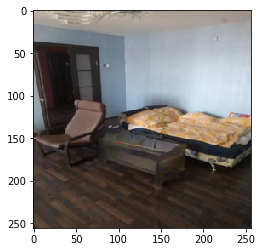

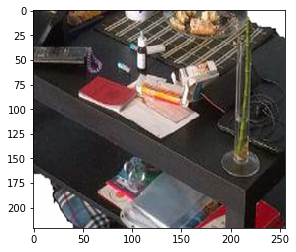

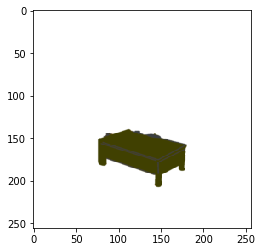

In [78]:
# (149, 200, 3)

content_filename = '../pix2pix-tensorflow/live_tests/test1/generated_table.png'
content_image = load_image(content_filename, max_size=256)
plt.figure()
plt.imshow(content_image/256)

# style_filename = '/home/alexander/Desktop/3.jpeg'
style_filename = '../pix2pix-tensorflow/live_tests/test1/table_style.png'
style_image = load_image(style_filename, max_size=256)[:,:,:3]
plt.figure()
plt.imshow(style_image/256)

mask_filename = '../pix2pix-tensorflow/live_tests/test1/table_mask.png'
mask_image = imresize(imread(mask_filename), [256, 256])
plt.figure()
plt.imshow(mask_image/256)

(4413,)

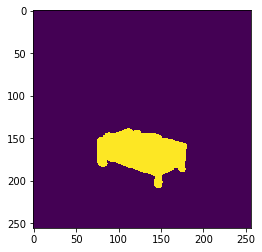

In [20]:
content_mask = np.where(mask_image.mean(axis = 2) > 0, 1.0, 0.0)
content_masked = (np.concatenate([np.expand_dims(content_mask, axis=2)]*3, axis=2)*256).astype(int)
plt.imshow(content_mask)

In [11]:
model = vgg16.VGG16()
session = tf.InteractiveSession(graph=model.graph)

In [82]:
content_layer_ids = [4]
style_layer_ids = list(range(3, 5))
weight_content=1.5
weight_style=20.0
weight_denoise=0.3
num_iterations=100
step_size=5.0

In [83]:
loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

# Create the loss-function for the style-layers and -image.
loss_style = create_style_loss(session=session,
                                model=model,
                                style_image=style_image,
                                layer_ids=style_layer_ids)    

loss_denoise = create_denoise_loss(model)

adj_content = tf.Variable(1e-10, name='adj_content')
adj_style = tf.Variable(1e-10, name='adj_style')
adj_denoise = tf.Variable(1e-10, name='adj_denoise')

session.run([adj_content.initializer,
             adj_style.initializer,
             adj_denoise.initializer])

update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

loss_combined = weight_content * adj_content * loss_content + \
    weight_style * adj_style * loss_style + \
    weight_denoise * adj_denoise * loss_denoise

# loss_combined = weight_content * adj_content * loss_content
    
# loss_combined = weight_style * adj_style * loss_style + \
#     weight_denoise * adj_denoise * loss_denoise

gradient = tf.gradients(loss_combined, model.input)

run_list = [gradient, update_adj_content, update_adj_style, \
            update_adj_denoise]


In [1]:
mixed_image = content_image.copy()
# mixed_image = np.random.rand(*content_image.shape) + 128
# mixed_image[np.where(content_masked != 0.0)] = 0
# mixed_image = content_image.copy()


for i in range(num_iterations):
    feed_dict = model.create_feed_dict(image=mixed_image)

    grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
    grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
    step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
#     mixed_image[np.where(content_mask == 1.0)] -= (grad * step_size_scaled)[np.where(content_mask == 1.0)]
    mixed_image -= (grad * step_size_scaled)

        # Ensure the image has valid pixel-values between 0 and 255.
    mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
    print(". ", end="")

        # Display status once every 10 iterations, and the last.
    if (i % 50 == 0) or (i == num_iterations - 1):
        print()
        print("Iteration:", i)

            # Print adjustment weights for loss-functions.
        msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
        print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

        fig = plt.figure(figsize=(20,20))
        fig.add_subplot(1, 3, 1)
        plt.imshow(content_image/256)
        fig.add_subplot(1, 3, 2)
        plt.imshow(mixed_image/256)
        fig.add_subplot(1, 3, 3)
        plt.imshow(style_image/256)
        plt.show()

NameError: name 'content_image' is not defined

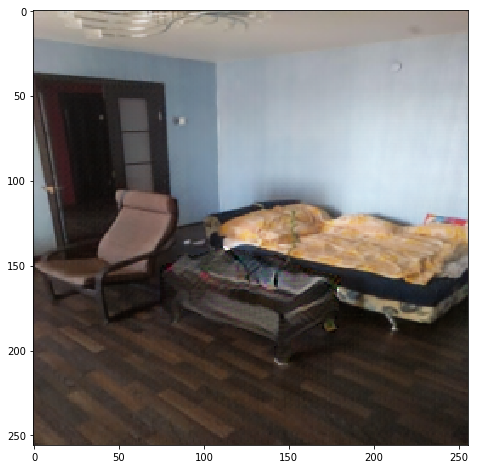

In [85]:
res = content_image.copy()
res[np.where(content_mask == 1.0)] = mixed_image[np.where(content_mask == 1.0)]
plt.figure(figsize=(8,8))
plt.imshow(res/256)

In [15]:
session.run([tf.shape(layer) for layer in model.get_layer_tensors(style_layer_ids)], feed_dict=feed_dict)

[array([  1, 256, 256,  64], dtype=int32),
 array([  1, 128, 128, 128], dtype=int32),
 array([  1, 128, 128, 128], dtype=int32)]

In [26]:
model.get_layer_tensors(style_layer_ids)[0].get_shape()

TensorShape([Dimension(None), Dimension(None), Dimension(None), Dimension(64)])

In [35]:
model.get_layer_tensors(content_layer_ids)

[<tf.Tensor 'conv3_1/conv3_1:0' shape=(?, ?, ?, 256) dtype=float32>]

In [12]:
truncated_graph = tf.graph_util.extract_sub_graph(model.graph.as_graph_def(), ["conv3_1/conv3_1"])

In [13]:
tf.train.write_graph(truncated_graph, ".", "truncated.pb", as_text=False)

'./truncated.pb'